# STATS 780 Assignment 2 - Logistic and K-Nearest Neighbor Classification

John Tweedie - SN#: 400550023

## Data Pre-Processing

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
import statsmodels.api as sm
from statsmodels.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
warnings.filterwarnings('ignore')

# import and view Austraila Weather/Rainfall data
raw_data = pd.read_csv(r"weatherAUS.csv")

raw_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [147]:
# data info
# null data in Rainfall, Evaporation, Sunshin, Cloud9am, and Could3pm are noted
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [148]:
# create a subset of data to work with
# removed variables with significant missing data
# Rahmatullah et al. (2012) suggests evaporation is an important variable, 
# so we will leave this despite the missing data
df = raw_data[['Location', 'Date', 'MinTemp', 'MaxTemp', 'Rainfall',
               'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 
               'Humidity9am', 'Humidity3pm',
               'Pressure9am', 'Pressure3pm', 'Temp9am',
               'Temp3pm', 'RainToday', 'RainTomorrow', 'Evaporation']]

# create a column for the day number of a given year (i.e. 1-365) and Unix timestamp
df['Date'] = pd.to_datetime(df['Date'])
df['DateIndex'] = df['Date'].copy()

df['DayNum'] = df['Date'].dt.dayofyear

# set multi-index based on Location (of weather station) and Date
df = df.set_index(['Location','DateIndex'])

# convert RainTommorow into 1s and 0s to work in regression setting
df.loc[:,'RainTomorrow'] = df['RainTomorrow'].map({'Yes':1, 'No':0})

In [149]:
# Decreasing air pressure is known to preceed rainfall events
# low-pressure fronts are also associated with changes in wind patterns
# Similary, we can expect changes in humidity and temperature preceeding rainfall

# To capture this, we will calculate the change in weather parameters on the day as 
# the average of the preceeding day and Pressure/Windspeed/Humidity/Temp9am on 
# the day-of minus Pressure/Windspeed/Humidity/Temp3pm on the day-of
df['AvgPressurePreceeding'] = None

# itterate through all cities
locations = df.index.get_level_values('Location').unique()
for location in locations:
    
    # sort by the date index, just to be sure they are in order
    df.loc[location].sort_index(ascending=False)
    
    # calculate the average preceeding air pressure (past day and the 9am pressure)
    df.loc[location,'AvgPressurePreceeding'] = (df['Pressure9am'].rolling(window=2, min_periods=2).sum() 
                                                + df['Pressure3pm'].shift(1))/3 
    
    # calculate the average preceeding wind speed (past day and the 9am speed)
    df.loc[location,'AvgWindSpeedPreceeding'] = (df['WindSpeed9am'].rolling(window=2, min_periods=2).sum() 
                                                + df['WindSpeed3pm'].shift(1))/3
    
    # calculate the average preceeding humidity...
    df.loc[location,'AvgHumidityPreceeding'] = (df['Humidity9am'].rolling(window=2, min_periods=2).sum() 
                                                + df['Humidity3pm'].shift(1))/3
    
    # calculate the average preceeding temperature...
    df.loc[location,'AvgTempPreceeding'] = (df['Temp9am'].rolling(window=2, min_periods=2).sum() 
                                                + df['Temp3pm'].shift(1))/3 
    
# calculate the pressure/wind speed/humidity/temperature difference at 3pm
df['PressureDif'] = df['Pressure3pm'] - df['AvgPressurePreceeding']
df['WindSpeedDif'] = df['WindSpeed3pm'] - df['AvgWindSpeedPreceeding']
df['HumidityDif'] = df['Humidity3pm'] - df['AvgHumidityPreceeding']
df['TempDif'] = df['Temp3pm'] - df['AvgTempPreceeding']

# calculate difference in daily wind gust speed
df['WindGustSpeedDif'] = df['WindGustSpeed'].diff()

In [150]:
# Must check for continuity of timeseries - missing days are an issue for rolling calculations:
#(commented out b/c it prints out a lot of text...)

# for location in locations:
#     print(location,':')
#     print(df.loc[location]['Date'].diff().unique())

# From this, it was noted that there are gaps in the data

# We will get rid of all rows that do not have a 1-day timestep from the previous
df = df[df['Date'].diff() == '1 days']

# Finally, get rid of any rows still missing data
# interpolation is not suitable due to large intraday variability in weather parameters
df = df.dropna()

## Data Visualization

In [151]:
# Pre-processing and cleaning of the daraset is complete
# Can now proceed with analysis

<Figure size 400x400 with 0 Axes>

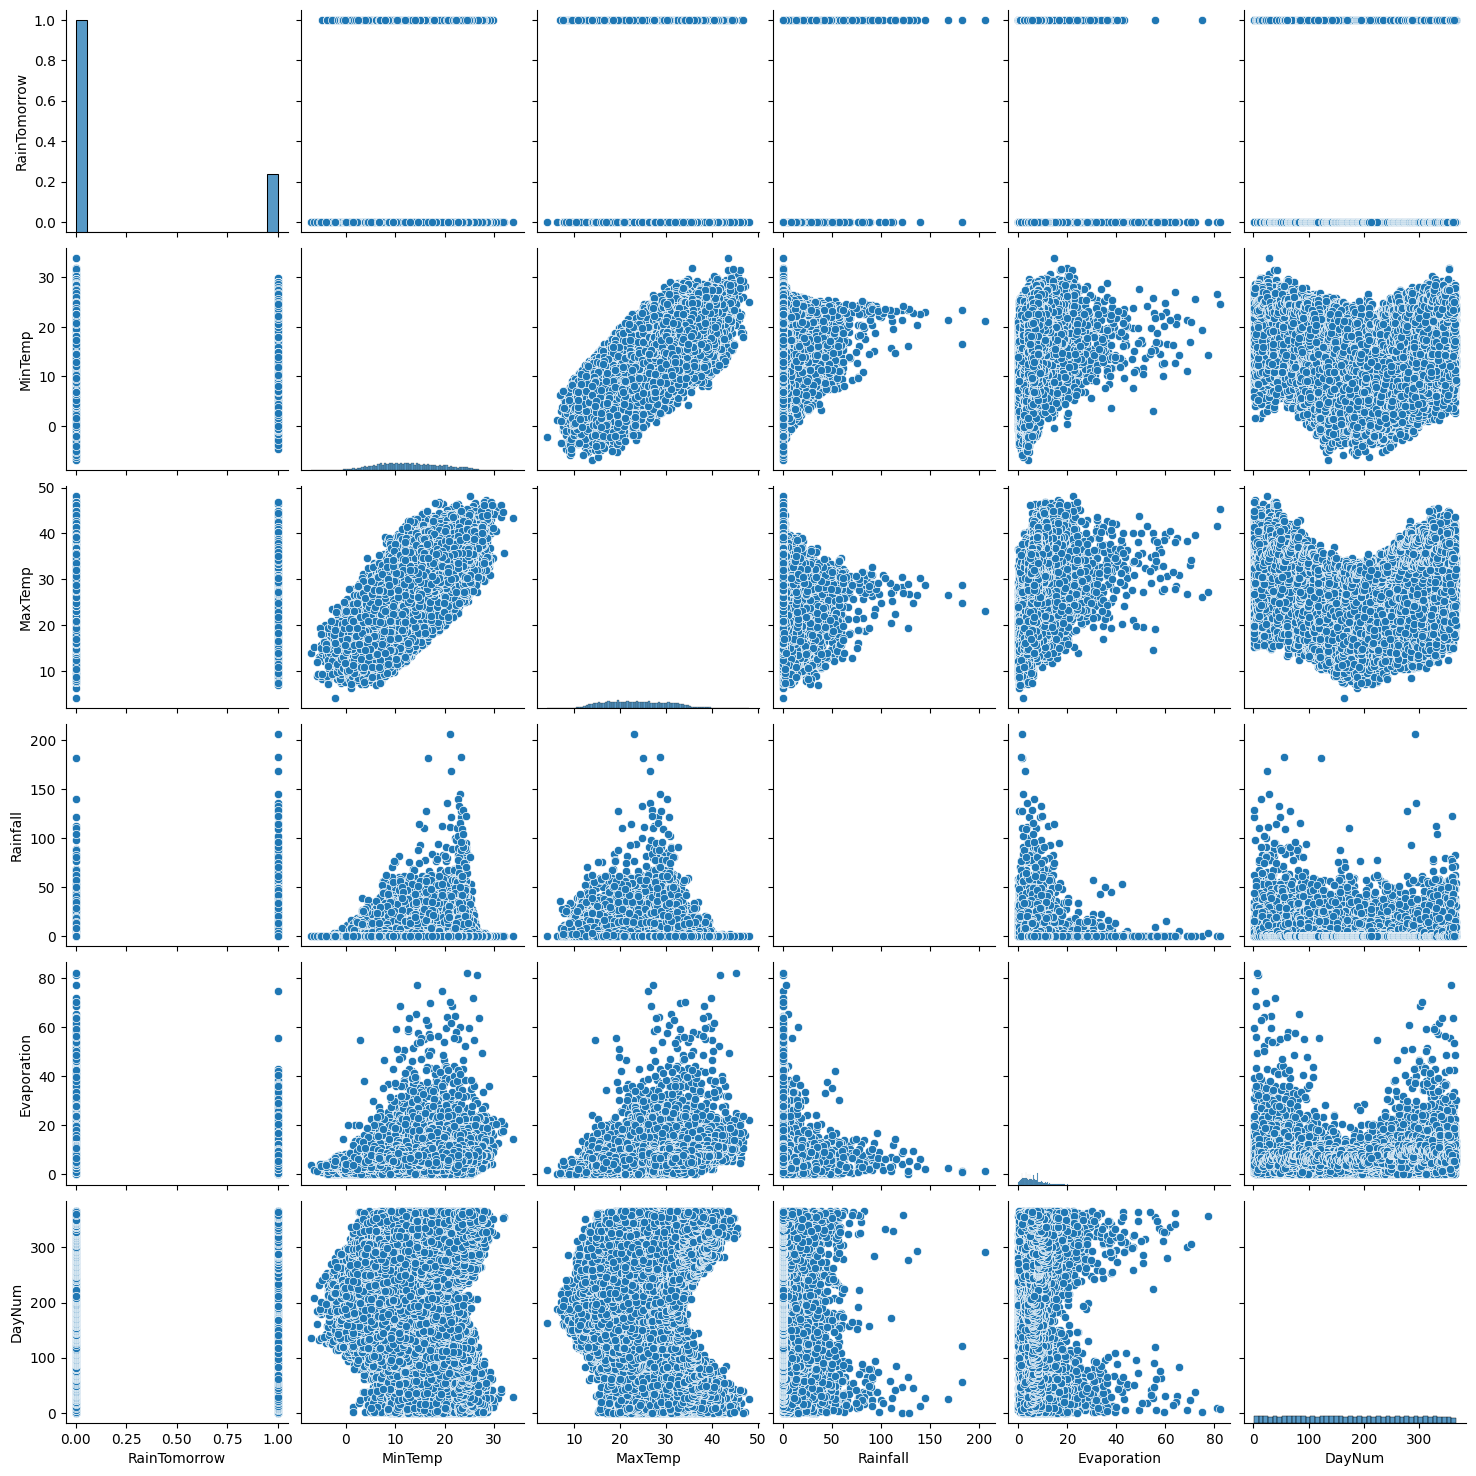

In [ ]:
plt.figure(figsize=(4, 4))
sns.pairplot(df[['RainTomorrow','MinTemp', 'MaxTemp', 'Rainfall', 'RainToday',
                'Evaporation', 'DayNum']])
plt.show()

In [ ]:
# sns.pairplot(df[['RainTomorrow','WindSpeed9am', 'WindSpeed3pm', 'WindGustSpeed',
#                  'AvgWindSpeedPreceeding','WindSpeedDif', 'WindGustSpeedDif']])

In [ ]:
# sns.pairplot(df[['RainTomorrow', 'Humidity9am', 'Humidity3pm', 'AvgHumidityPreceeding', 'HumidityDif']])

In [ ]:
# sns.pairplot(df[['RainTomorrow', 'Pressure9am', 'Pressure3pm',
#                  'AvgPressurePreceeding','PressureDif']])

In [156]:
# Split data into test (hold-out) and training sets

def preprocess_predictor_vars():
    predictors = ['Rainfall', 'Evaporation', 'DayNum',
                  'WindGustSpeed', 'WindGustSpeedDif',
                  'WindSpeed9am', 'WindSpeed3pm', 'WindSpeedDif',
                  'Humidity9am', 'Humidity3pm', 'HumidityDif',
                  'Pressure9am', 'Pressure3pm', 'PressureDif',
                  'MinTemp', 'MaxTemp', 
                  'Temp9am', 'Temp3pm', 'TempDif']

    X = df[predictors]


    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X),columns=predictors, index=X.index)

    y = df[['RainTomorrow',]].astype('int')
    X_scaled = add_constant(X_scaled)
    
    return X, X_scaled, y

    
X, X_scaled, y = preprocess_predictor_vars()
    
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, random_state=100)

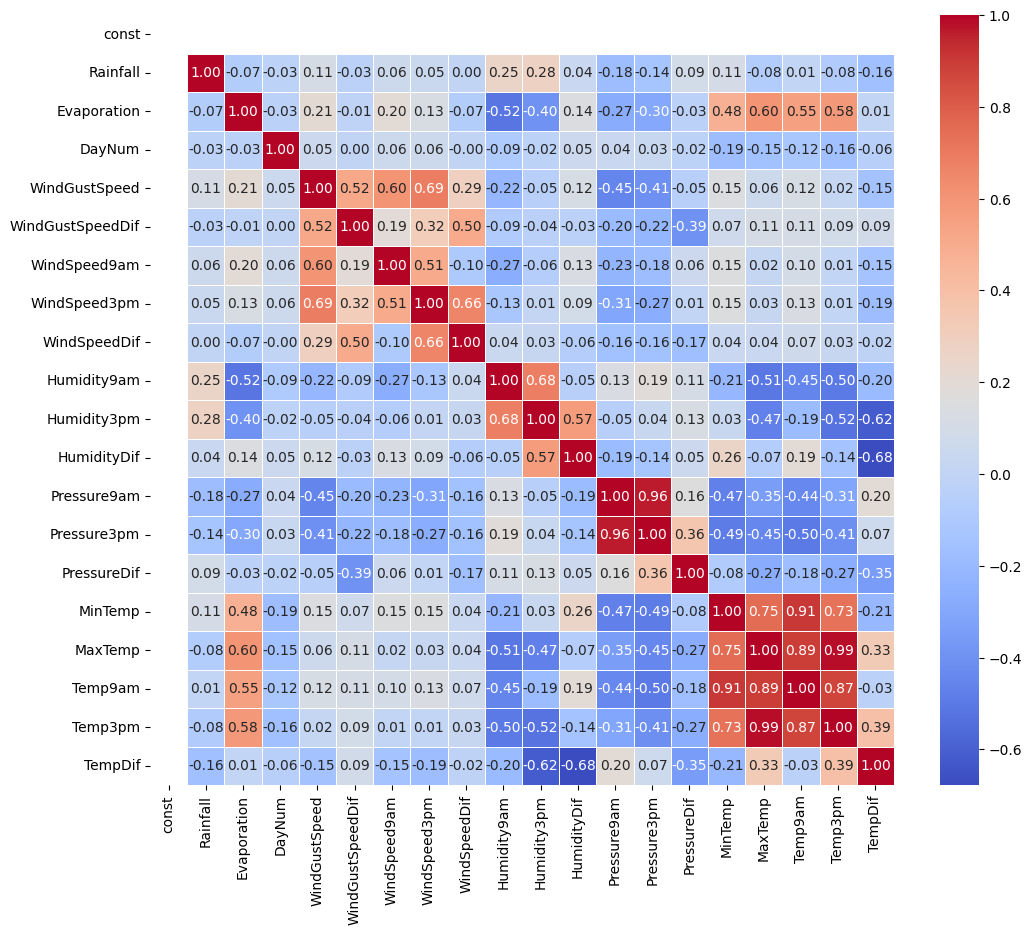

In [157]:
# View correlation matrix of all possible predictors
# Many predictors are highly correlated with one another, suggesting we will need
# likely to reduce the number of predictors in the models
plt.figure(figsize=(12, 10))
correlation_matrix = X_scaled.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.4)
plt.show()

In [158]:
# create a function to print out model logistic performance (missclassification, AUC, cross-val...)

def model_performance(model):

    y_prob = model.predict(X_test)
    
    try:
        y_pred = round(y_prob)
        con_mtx = confusion_matrix(y_test, y_pred)
        clf_report = classification_report(y_test, y_pred)
        
    except:
        con_mtx = confusion_matrix(y_test, y_prob)
        clf_report = classification_report(y_test, y_prob)
    
    print('\nCross Validation Results for Rain (+) vs. No-Rain (-) Precitions:')
    print('====================================================================================')
    print('\nTrue positives:', con_mtx[1][1])
    print('False positives:', con_mtx[0][1])
    print('True negatives:', con_mtx[0][0])
    print('False negatives:', con_mtx[1][0])
    print('Precision: ', round((con_mtx[1][1]/(con_mtx[1][1]+con_mtx[0][1])),3)) # ratio of true+ to total predicted
    print('Specificity: ', round((con_mtx[0][0]/(con_mtx[0][0]+con_mtx[0][1])),3))
    print('Accuracy: ', round((con_mtx[1][1]+con_mtx[0][0])/len(X_test),3))
    print('Missclass. Rate: ', round((con_mtx[0][1]+con_mtx[1][0])/len(X_test),3))

    print('\nclf report: \n')
    print(clf_report)
    
    

# K-Nearest Neighbor Classification

In [159]:
# reset and re-split the predictor variable subset
X, X_scaled, y = preprocess_predictor_vars()
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, random_state=100)

In [160]:
# fit the full model
clf_kn = KNeighborsClassifier().fit(X_train, y_train)

# use the function to evaluate performance
model_performance(clf_kn)


Cross Validation Results for Rain (+) vs. No-Rain (-) Precitions:

True positives: 3925
False positives: 1783
True negatives: 27120
False negatives: 3955
Precision:  0.688
Specificity:  0.938
Accuracy:  0.844
Missclass. Rate:  0.156

clf report: 

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     28903
           1       0.69      0.50      0.58      7880

    accuracy                           0.84     36783
   macro avg       0.78      0.72      0.74     36783
weighted avg       0.83      0.84      0.83     36783



In [161]:
# Find optimal tuning parameter for K-Nearest Neighbors model
# Note that even values of k result in poorer classification, likely due to the occurence of equal number
# of values on ether side of the classifier, which is not possible with an odd k

tuning_results = pd.DataFrame()

for K in range(1,201,10):
    clf_kn = KNeighborsClassifier(n_neighbors=K)
    y_pred_kn = clf_kn.fit(X_train, y_train).predict(X_test) 
    con_mtx = confusion_matrix(y_test, y_pred_kn)
    Precision = round((con_mtx[1][1]/(con_mtx[1][1]+con_mtx[0][1])),3)
    Specificity = round((con_mtx[0][0]/(con_mtx[0][0]+con_mtx[0][1])),3)
    Accuracy = round((con_mtx[1][1]+con_mtx[0][0])/len(X_test),3)
    Missclass = round((con_mtx[0][1]+con_mtx[1][0])/len(X_test),3)
    
    results_list = [K, con_mtx[1][1], con_mtx[0][1], con_mtx[0][0], 
                    con_mtx[1][0], Precision, Specificity, Accuracy, Missclass]
    
    tuning_results = pd.concat([tuning_results, pd.DataFrame([results_list])], ignore_index=True)

columns=['Tuning Parameter', 'True Positives', 'False Positives', 'True Negatives',
         'False Negatives', 'Precision', 'Specificity', 'Accuracy', 'Missclass Rate']
tuning_results = tuning_results.rename(columns=dict(zip(tuning_results.columns, columns)))

tuning_results

,Tuning Parameter,True Positives,False Positives,True Negatives,False Negatives,Precision,Specificity,Accuracy,Missclass Rate
0,1,4232,3363,25540,3648,0.557,0.884,0.809,0.191
1,11,3772,1415,27488,4108,0.727,0.951,0.850,0.150
2,21,3673,1174,27729,4207,0.758,0.959,0.854,0.146
3,31,3577,1104,27799,4303,0.764,0.962,0.853,0.147
4,41,3506,1044,27859,4374,0.771,0.964,0.853,0.147
5,51,3460,992,27911,4420,0.777,0.966,0.853,0.147
6,61,3422,984,27919,4458,0.777,0.966,0.852,0.148
7,71,3383,941,27962,4497,0.782,0.967,0.852,0.148
8,81,3326,921,27982,4554,0.783,0.968,0.851,0.149
9,91,3319,876,28027,4561,0.791,0.970,0.852,0.148


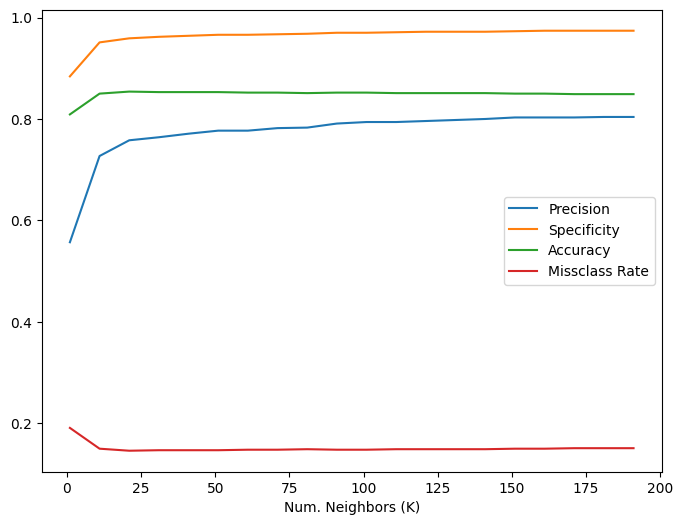

In [162]:
plt.figure(figsize=(8, 6))
plt.plot(tuning_results['Tuning Parameter'], tuning_results[['Precision', 'Specificity', 
                                                             'Accuracy', 'Missclass Rate']],
         label=['Precision', 'Specificity','Accuracy', 'Missclass Rate'])
plt.legend()
plt.xlabel('Num. Neighbors (K)')
plt.show()

In [163]:
# Based on the above, it appears that a value of 21 neighbors minimizes the missclassification rate
# and maintains acceptable levels of precision and specificity.
# Therefore, the final K-Nearest Neighbors model is as follows:

clf_kn = KNeighborsClassifier(n_neighbors=21).fit(X_train, y_train)
model_performance(clf_kn)


Cross Validation Results for Rain (+) vs. No-Rain (-) Precitions:

True positives: 3673
False positives: 1174
True negatives: 27729
False negatives: 4207
Precision:  0.758
Specificity:  0.959
Accuracy:  0.854
Missclass. Rate:  0.146

clf report: 

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     28903
           1       0.76      0.47      0.58      7880

    accuracy                           0.85     36783
   macro avg       0.81      0.71      0.74     36783
weighted avg       0.84      0.85      0.84     36783



# Logisitic Regression Classification

In [164]:
# We will start by selecting a subset of variables using backwards stepwise selection,
# with LASSO regularization finalizing the model paramaters and coefficients

# reset and re-split the predictor variable subset
X, X_scaled, y = preprocess_predictor_vars()
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, random_state=100)

# Fitting the full initial logisitic classsifier model
clf_lg = sm.Logit(y_train, X_train).fit()
print(clf_lg.summary())

# Evaluate performance
model_performance(clf_lg)

Optimization terminated successfully.
         Current function value: 0.344562
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           RainTomorrow   No. Observations:                36782
Model:                          Logit   Df Residuals:                    36762
Method:                           MLE   Df Model:                           19
Date:                Tue, 17 Oct 2023   Pseudo R-squ.:                  0.3399
Time:                        19:43:13   Log-Likelihood:                -12674.
converged:                       True   LL-Null:                       -19201.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.8895      0.020    -95.218      0.000      -1.928      -1.851
Rainfall   

In [165]:
# Remove predictors with large p-values, unlikely to be associated with response

X_scaled = X_scaled[['const', 'Rainfall', 'Evaporation',
              'WindGustSpeed',
              'WindSpeed3pm', 'WindSpeedDif',
              'Humidity9am', 'Humidity3pm', 'HumidityDif',
              'Pressure9am', 'Pressure3pm', 'PressureDif']]

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, random_state=100)

In [166]:
# Re-fit the model
clf_lg = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.345458
         Iterations 7


In [167]:
# Investigate potential issues regardi
# investigating collinearity using VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_vif = pd.DataFrame()
df_vif['Predictor'] = X_test.columns
df_vif['VIF'] = [variance_inflation_factor(X_test, i) for i in range(X_test.shape[1])]
df_vif

,Predictor,VIF
0,const,1.000143
1,Rainfall,1.187733
2,Evaporation,1.732424
3,WindGustSpeed,2.544602
4,WindSpeed3pm,3.678474
5,WindSpeedDif,2.217467
6,Humidity9am,4.347681
7,Humidity3pm,7.544680
8,HumidityDif,3.900041
9,Pressure9am,32.257458


In [168]:
# Remove predictors with large VIF (>10) and re-fit model
X_scaled = X_scaled[['const', 'Rainfall', 'Evaporation',
              'WindGustSpeed',
              'WindSpeed3pm', 'WindSpeedDif',
              'Humidity3pm', 'HumidityDif',
              'Pressure3pm', 'PressureDif']]

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, random_state=100)

clf_lg = sm.Logit(y_train, X_train).fit()
print(clf_lg.summary())
model_performance(clf_lg)

Optimization terminated successfully.
         Current function value: 0.347307
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           RainTomorrow   No. Observations:                36782
Model:                          Logit   Df Residuals:                    36772
Method:                           MLE   Df Model:                            9
Date:                Tue, 17 Oct 2023   Pseudo R-squ.:                  0.3347
Time:                        19:43:14   Log-Likelihood:                -12775.
converged:                       True   LL-Null:                       -19201.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.8634      0.019    -96.484      0.000      -1.901      -1.826
Rainfall          0.

In [169]:
# All p-values suggest each predictor is associated with the response
# We will check the VIF of this subest to check for potential colinearlity issues

df_vif = pd.DataFrame()
df_vif['Predictor'] = X_test.columns
df_vif['VIF'] = [variance_inflation_factor(X_test, i) for i in range(len(X_test.columns))]
df_vif

# VIF below suggests colinearlity is not an issue for this model

,Predictor,VIF
0,const,1.000126
1,Rainfall,1.187505
2,Evaporation,1.725259
3,WindGustSpeed,2.397557
4,WindSpeed3pm,3.624894
5,WindSpeedDif,2.187499
6,Humidity3pm,2.626241
7,HumidityDif,2.107123
8,Pressure3pm,1.541428
9,PressureDif,1.292335


## Cutoff tuning parameter optimization

In [170]:
# Find optimal tuning parameter for Logistic model

Ps = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # list of tuning parameter values
clf_lg = sm.Logit(y_train, X_train).fit() # fresh re-fit of model 
tuning_results = pd.DataFrame()


# itterate through all 
for P in Ps:
    
    y_prob = clf_lg.predict(X_test)

    y_pred = np.where(y_prob > P, 1, 0)
    con_mtx = confusion_matrix(y_pred, y_test['RainTomorrow'])

    Precision = round((con_mtx[1][1]/(con_mtx[1][1]+con_mtx[1][0])),3)
    Specificity = round((con_mtx[0][0]/(con_mtx[0][0]+con_mtx[1][0])),3)
    Accuracy = round((con_mtx[1][1]+con_mtx[0][0])/len(X_test),3)
    Missclass = round((con_mtx[0][1]+con_mtx[1][0])/len(X_test),3)
    
    results_list = [P, con_mtx[1][1], con_mtx[1][0], con_mtx[0][0], 
                    con_mtx[0][1], Precision, Specificity, Accuracy, Missclass]
    
    tuning_results = pd.concat([tuning_results, pd.DataFrame([results_list])], ignore_index=True)

columns=['Tuning Parameter', 'True Positives', 'False Positives', 'True Negatives',
         'False Negatives', 'Precision', 'Specificity', 'Accuracy', 'Missclass Rate']
tuning_results = tuning_results.rename(columns=dict(zip(tuning_results.columns, columns)))

tuning_results

Optimization terminated successfully.
         Current function value: 0.347307
         Iterations 7


,Tuning Parameter,True Positives,False Positives,True Negatives,False Negatives,Precision,Specificity,Accuracy,Missclass Rate
0,0.1,7214,12030,16873,666,0.375,0.584,0.655,0.345
1,0.2,6204,6171,22732,1676,0.501,0.786,0.787,0.213
2,0.3,5338,3621,25282,2542,0.596,0.875,0.832,0.168
3,0.4,4605,2235,26668,3275,0.673,0.923,0.850,0.150
4,0.5,3938,1451,27452,3942,0.731,0.950,0.853,0.147
5,0.6,3275,937,27966,4605,0.778,0.968,0.849,0.151
6,0.7,2552,558,28345,5328,0.821,0.981,0.840,0.160
7,0.8,1858,267,28636,6022,0.874,0.991,0.829,0.171
8,0.9,1012,96,28807,6868,0.913,0.997,0.811,0.189


Text(0.5, 0, 'Cutoff')

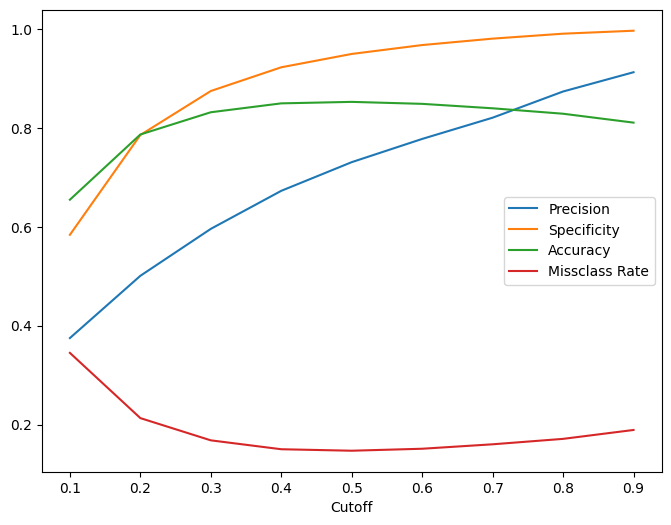

In [171]:
plt.figure(figsize=(8, 6))
plt.plot(tuning_results['Tuning Parameter'], tuning_results[['Precision', 'Specificity', 
                                                             'Accuracy', 'Missclass Rate']],
         label=['Precision', 'Specificity','Accuracy', 'Missclass Rate'])
plt.legend()
plt.xlabel('Cutoff')

# From the tuning parameter dataframe and plot, a cutoff tuning parameter of 0.5 (default) seems appropriate:
# with 0.5, we would correctly predict rainfall days and dry days 82% and 84% of the time, respectively 

# We now have a tuned and reduced logistic model. Further reductions will be completed using LASSO method

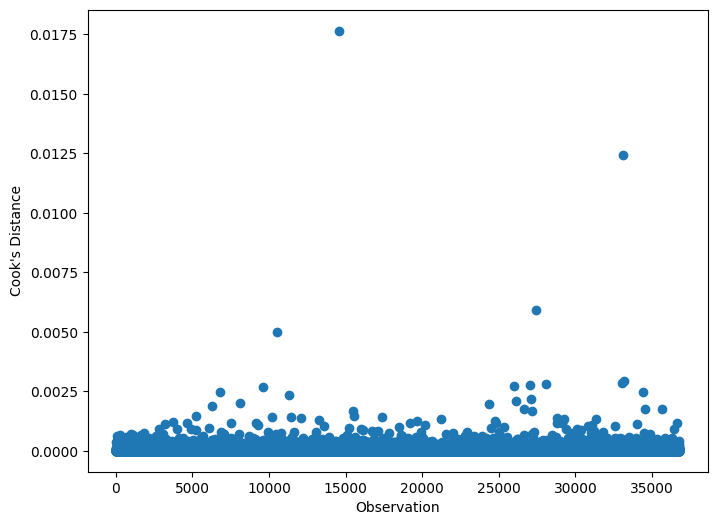

In [172]:
# Using a Cook's distance test to check for problematic outliers
influence = clf_lg.get_influence()
cooks_dist = influence.cooks_distance
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(len(cooks_dist[0])), cooks_dist[0])
plt.ylabel("Cook's Distance")
plt.xlabel("Observation")
plt.show()

# The plot shows a maximum value of 0.0175
# A typical cutoff is much higher (~4)
# As such, these values are not problematic as outliers

## LASSO Regularization Logisitic Regression

In [173]:
# We will perform LASSO regularization to shrink the regression coefficients
# Several tuning parameters (penalty coefficients) will be evaluated to select the best-performing model

# list of all tuning parameters to test, full coefficient shrinkage begins at ~0.005
Cs = [1, 0.1, 0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.0001]

# initialize dataframes
lasso_coefs = pd.DataFrame({'Feature': X_train.columns})
lasso_cv = pd.DataFrame()
lasso_model = sm.Logit(y_train, X_train)

# itterate through tuning paramters, store results in initialized dataframes
for c in Cs:
    
    clf_lasso = lasso_model.fit_regularized(method='l1', L1_wt=1, alpha=(1/c), disp=False) # alpha is the (inverse) penalty term
    y_prob = clf_lasso.predict(X_test)
    y_pred = round(y_prob)
    con_mtx = confusion_matrix(y_test, y_pred)
    
    lasso_coefs['coef_C={}'.format(c)] = clf_lasso.params.values
    
    # calculate cross validation metrics
    Precision = round((con_mtx[1][1]/(con_mtx[1][1]+con_mtx[0][1])),3)
    Specificity = round((con_mtx[0][0]/(con_mtx[0][0]+con_mtx[0][1])),3)
    Accuracy = round((con_mtx[1][1]+con_mtx[0][0])/len(X_test),3)
    Missclass = round((con_mtx[0][1]+con_mtx[1][0])/len(X_test),3)
    
    results_list = [c, con_mtx[1][1], con_mtx[0][1], con_mtx[0][0], 
                    con_mtx[1][0], Precision, Specificity, Accuracy, Missclass]
    
    # store cross validation metrics in dataframe
    lasso_cv = pd.concat([lasso_cv, pd.DataFrame([results_list])], ignore_index=True)

columns=['Tuning Parameter', 'True Positives', 'False Positives', 'True Negatives',
         'False Negatives', 'Precision', 'Specificity', 'Accuracy', 'Missclass Rate']
lasso_cv = lasso_cv.rename(columns=dict(zip(lasso_cv.columns, columns)))

lasso_coefs

,Feature,coef_C=1,coef_C=0.1,coef_C=0.01,coef_C=0.005,coef_C=0.0025,coef_C=0.001,coef_C=0.0005,coef_C=0.00025,coef_C=0.0001
0,const,-1.862639,-1.855615,-1.791384,-1.730276,-1.626212,-1.385823,-1.107815,-0.751859,-0.047854
1,Rainfall,0.259057,0.256493,0.232662,0.210106,0.175125,0.097612,0.014049,0.000000,0.000000
2,Evaporation,-0.139632,-0.134713,-0.089538,-0.039894,0.000000,0.000000,0.000000,0.000000,0.000000
3,WindGustSpeed,0.900366,0.889463,0.786731,0.704303,0.562696,0.343765,0.190090,0.000000,0.000000
4,WindSpeed3pm,-0.502552,-0.486963,-0.339285,-0.257185,-0.130666,0.000000,0.000000,0.000000,0.000000
5,WindSpeedDif,0.119375,0.109460,0.015382,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Humidity3pm,1.345296,1.342905,1.321722,1.296312,1.218709,0.987334,0.714649,0.350273,0.000000
7,HumidityDif,0.149573,0.144480,0.096787,0.060659,0.026996,0.000000,0.000000,0.000000,0.000000
8,Pressure3pm,-0.359269,-0.356956,-0.335680,-0.312779,-0.282086,-0.232957,-0.155764,0.000000,0.000000
9,PressureDif,-0.326286,-0.325134,-0.314685,-0.290698,-0.240192,-0.111083,0.000000,0.000000,0.000000


In [174]:
lasso_cv

,Tuning Parameter,True Positives,False Positives,True Negatives,False Negatives,Precision,Specificity,Accuracy,Missclass Rate
0,1.00000,3936,1451,27452,3944,0.731,0.950,0.853,0.147
1,0.10000,3931,1444,27459,3949,0.731,0.950,0.853,0.147
2,0.01000,3874,1386,27517,4006,0.737,0.952,0.853,0.147
3,0.00500,3817,1334,27569,4063,0.741,0.954,0.853,0.147
4,0.00250,3691,1229,27674,4189,0.750,0.957,0.853,0.147
5,0.00100,3326,979,27924,4554,0.773,0.966,0.850,0.150
6,0.00050,2671,550,28353,5209,0.829,0.981,0.843,0.157
7,0.00025,476,56,28847,7404,0.895,0.998,0.797,0.203
8,0.00010,0,0,28903,7880,NaN,1.000,0.786,0.214


In [175]:
# From this, we can see that a shrinkage coefficient of approximatley 0.0025 may be appropriate
# Anything less than this, the accuracy/missclassification rates largely resemble the null/baseline
# rates (i.e. if we only predicited 0, no matter what)
#
# In this application, predicting next-day rain is likely more valuable than predicting a dry day
# As such, more emphasis should be placed on precision, but also the total amount of True Posisitves,
# since the precision rates increase as both True and False Positives fall if False increases more rapidly.

# A value of 0.0025 provides shrinkage such that the sparse model would contain 2 fewer varibles than
# the original model, while still maintaing comparable and acceptable levels of accuracy.

In [176]:
# The sparse logstic model is as follows:
clf_lasso = lasso_model.fit_regularized(method='l1', L1_wt=1, alpha=(1/0.0025))
print(clf_lasso.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.40131589509081367
            Iterations: 44
            Function evaluations: 44
            Gradient evaluations: 44
                           Logit Regression Results                           
Dep. Variable:           RainTomorrow   No. Observations:                36782
Model:                          Logit   Df Residuals:                    36774
Method:                           MLE   Df Model:                            7
Date:                Tue, 17 Oct 2023   Pseudo R-squ.:                  0.3200
Time:                        19:43:16   Log-Likelihood:                -13056.
converged:                       True   LL-Null:                       -19201.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

In [177]:
# It is noted that HumidityDif now has a high p-value, we will remove it and re-fit
X_scaled = X_scaled[['const', 'Rainfall', 'Evaporation',
              'WindGustSpeed',
              'WindSpeed3pm', 'WindSpeedDif',
              'Humidity3pm',
              'Pressure3pm', 'PressureDif']]

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, random_state=100)

lasso_model = sm.Logit(y_train, X_train)
clf_lasso = lasso_model.fit_regularized(method='l1', L1_wt=1, alpha=(1/0.0025))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4013427368039725
            Iterations: 40
            Function evaluations: 40
            Gradient evaluations: 40


In [178]:
# The final sparese model is as follows:
print(clf_lasso.summary())
model_performance(clf_lasso)
final_model = pd.DataFrame({'Predictor': X_train.columns, 'Coefficient': clf_lasso.params.values,
                           'p-value': clf_lasso.pvalues, 
                            'VIF': [variance_inflation_factor(X_test, i) for i in range(len(X_test.columns))]})

final_model

                           Logit Regression Results                           
Dep. Variable:           RainTomorrow   No. Observations:                36782
Model:                          Logit   Df Residuals:                    36775
Method:                           MLE   Df Model:                            6
Date:                Tue, 17 Oct 2023   Pseudo R-squ.:                  0.3199
Time:                        19:43:16   Log-Likelihood:                -13059.
converged:                       True   LL-Null:                       -19201.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.6285      0.017    -96.437      0.000      -1.662      -1.595
Rainfall          0.1693      0.015     11.208      0.000       0.140       0.199
Evaporation            0        nan     

,Predictor,Coefficient,p-value,VIF
const,const,-1.628458,0.000000e+00,1.000124
Rainfall,Rainfall,0.169293,3.719412e-29,1.128512
Evaporation,Evaporation,0.000000,NaN,1.389839
WindGustSpeed,WindGustSpeed,0.566197,9.243942e-172,2.383652
WindSpeed3pm,WindSpeed3pm,-0.131650,1.072833e-11,3.616826
WindSpeedDif,WindSpeedDif,0.000000,NaN,2.151466
Humidity3pm,Humidity3pm,1.239530,0.000000e+00,1.319583
Pressure3pm,Pressure3pm,-0.285070,3.592410e-62,1.538706
PressureDif,PressureDif,-0.238655,1.527778e-51,1.290462


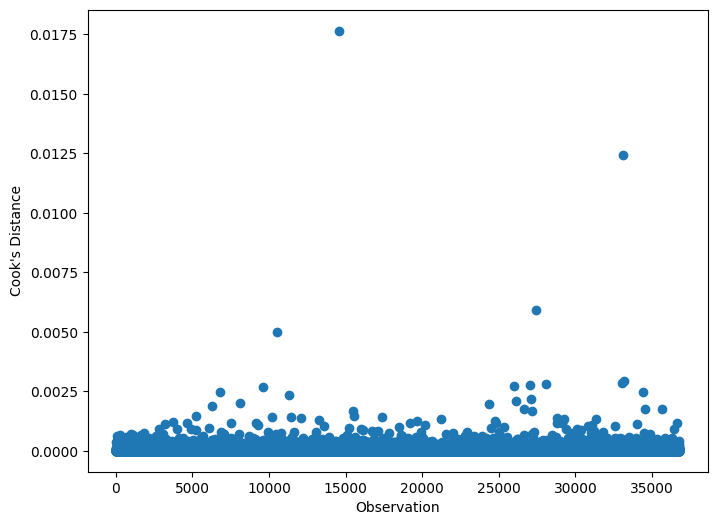

In [179]:
# Using a Cook's distance test to check for problematic outliers
influence = clf_lg.get_influence()
cooks_dist = influence.cooks_distance
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(len(cooks_dist[0])), cooks_dist[0])
plt.ylabel("Cook's Distance")
plt.xlabel("Observation")
plt.show()

In [180]:
# see what one standard deviation in humidity is, for interpretation purposes
X['Humidity3pm'].std()

20.518868436398154